In [539]:
# %load imports.py
%load_ext autoreload
%autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [540]:
import brian2 as br
from brian2.units import *
import numpy as np

In [541]:
import warnings 
def set_parameters_from_dict(neurongroup, dictionary_of_parameters):
    for param_key, param_value in dictionary_of_parameters.items():
        try: 
            neurongroup.__setattr__(param_key, param_value)
        except AttributeError as err:
            warnings.warn("{:s} has no paramater {:s}".format(neurongroup.name, param_key))

# Definition of the Neuron and Synapse Model

In [542]:
# Hodkin Huxley model from Brian2 documentation
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs = br.Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I + ih)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
''')

# # First H-current from Izhikevich p. 48 
# ghbar = 40. * nS #Other values would be 0.5, 2, 3.5, 20 depending on neuron type (Rothman, Manis)
# Eh = -43*mV
# V_half_h = -75.0
# k_h = -5.5
# V_max_h = -75.
# sigma_h = 15.
# C_amp_h = 1000.
# C_base_h = 100.
# eqs_ih = """
# ih = ghbar*r*(Eh-v) : amp
# dr/dt= (rinf-r)/rtau : 1
# rinf = 1. / (1+exp((V_half_h - v/mV) / k_h)) : 1
# rtau = (C_base_h + C_amp_h * exp(-(V_max_h-v/mV)**2./sigma_h**2)) * ms : second
# """
# Second H-current from Izhikevich p. 48 
ghbar = 40. * nS #Other values would be 0.5, 2, 3.5, 20 depending on neuron type (Rothman, Manis)
Eh = -1.*mV
V_half_h = -90.0
k_h = -9.
V_max_h = -75.
sigma_h = 20.
C_amp_h = 40.
C_base_h = 10.
eqs_ih = """
ih = ghbar*r*(Eh-v) : amp
dr/dt= (rinf-r)/rtau : 1
rinf = 1. / (1+exp((V_half_h - v/mV) / k_h)) : 1
rtau = (C_base_h + C_amp_h * exp(-(V_max_h-v/mV)**2./sigma_h**2)) * ms : second
"""

# eqs_ih = """
# ih = ghbar*r*(Eh-v) : amp
# dr/dt=(rinf-r)/rtau : 1
# rinf = 1. / (1+exp((v/mV + 90.) / 7.)) : 1
# # rtau = ((100000. / (237.*exp((v/mV+60.) / 12.) + 17.*exp(-(v/mV+60.) / 14.))) + 25.)*ms : second
# rtau = 0.01*(100. + 1000. * exp(-(-76.-v/mV)**2./15.**2)) * ms : second #From Izhikevich
# """

eqs += eqs_ih

delta_synapse_model = 'perturbation: volt'
delta_synapse = 'v+=perturbation'

threshold = "v>v_threshold"

neuron_properties = {
    "tau": 10*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "v_refractory": 'v > -40*mV',
    "u_ext": - 39 * mV
}

# pulse_strength = -10. * mV

neuron = br.NeuronGroup(N=1, \
                        name='single_neuron',\
                        model=eqs, \
                        threshold='v > -40*mV', \
                        refractory = 'v > -40*mV',\
                        method='exponential_euler')

set_parameters_from_dict(neuron, neuron_properties)
neuron.v = El
neuron.I = 0.7*nA

record_variables = ['v','ih']
spike_recorder = br.SpikeMonitor(source=neuron)
state_recorder = br.StateMonitor(neuron, record_variables, record=True)

auto_synapse = br.Synapses(source=neuron, target=neuron, model=delta_synapse_model, on_pre = delta_synapse, delay = 0.0 * ms)
auto_synapse.connect()


net = br.Network(neuron)
net.add(auto_synapse)
net.add(spike_recorder)
net.add(state_recorder)
net.store()


WARNING    /home/drangmeister/miniconda3/envs/micro_circuit_notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: single_neuron has no paramater tau
  import sys
 [py.warnings]
WARNING    /home/drangmeister/miniconda3/envs/micro_circuit_notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: single_neuron has no paramater v_threshold
  import sys
 [py.warnings]
WARNING    /home/drangmeister/miniconda3/envs/micro_circuit_notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: single_neuron has no paramater v_reset
  import sys
 [py.warnings]
WARNING    /home/drangmeister/miniconda3/envs/micro_circuit_notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: single_neuron has no paramater v_refractory
  import sys
 [py.warnings]
WARNING    /home/drangmeister/miniconda3/envs/micro_circuit_notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: single_neuron has no paramater u_ext
  import s

## Analysis Functions for the Spike Train

In [543]:
def run_sim(delay=0.0, pulse_strength=0.0, record_states=False, duration=50 * ms):
    net.restore()
    state_recorder.record = record_states
    auto_synapse.perturbation = pulse_strength
    auto_synapse.delay = delay
    
    net.run(duration=duration)

In [544]:
def get_mean_period(spike_train):
    return (np.max(spike_train) - np.min(spike_train)) / (spike_train.shape[0] - 1)

In [545]:
def get_mean_response(spike_trains_dict,t_isi):
    mean_response_dict = {}
#     t_isi = get_mean_period(spike_trains_dict[0.0 * ms])
    for delay, spike_train in spike_trains_dict.items():
        mean_response_dict[delay] = get_mean_period(spike_train) - t_isi
    return mean_response_dict

## Plotting Functions

In [546]:
import matplotlib.pyplot as plt

In [547]:
def plot_spiking(spike_trains_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for key, times in spike_trains_dict.items():
        ax.plot(times/ms, key*np.ones(times.shape), 'b.')
#     ax.plot(spike_train[0]/ms, np.ones(spike_train[0].shape), 'b|')

    ax.grid(axis='x')
#     ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Time(ms)");

In [548]:
def plot_mean_period(mean_period_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(list(mean_period_dict.keys()), list(mean_period_dict.values()), 'b')

    ax.grid(axis='x')
    ax.set_xlabel("Delay (ms)");

In [549]:
def plot_mean_response(mean_response_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.array(list(mean_response_dict.keys())), 1e3*np.array(list(mean_response_dict.values())), 'b')
    ax.plot(list(mean_response_dict.keys()), list(mean_response_dict.keys()), 'k--')

    ax.grid(axis='x')
    ax.set_xlabel("t_inh (ms)")
    ax.set_ylabel("exc_spike_delay (ms)");

In [550]:
def plot_delay_minus_response(mean_response_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    print(np.array(list(mean_response_dict.keys())))
    print(np.array(list(mean_response_dict.values())))
    print(np.array(list(mean_response_dict.keys()))-np.array(list(mean_response_dict.values())))
    ax.plot(list(mean_response_dict.keys()), np.array(list(mean_response_dict.keys()))-1e3*np.array(list(mean_response_dict.values())), 'b')

    ax.grid(axis='x')
    ax.set_xlabel("Delay (ms)");

In [551]:
def plot_phase_response_curve(mean_response_dict, t_isi):
    
    phi_inh = np.array(list(mean_response_dict.keys())) * ms / t_isi
    delta_phi = -np.array(list(mean_response_dict.values())) * second / t_isi
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(phi_inh, delta_phi, 'b')
    ax.plot(phi_inh, -phi_inh, 'k--')

    ax.grid(axis='x')
    ax.set_xlabel("phase of inhibition (ms)")
    ax.set_ylabel("phase shift (ms)");

## Execution

In [552]:
run_sim(record_states=True, pulse_strength=0.0*mV, duration=200 * ms)

In [553]:
t_state = state_recorder.t
v_state = state_recorder[1].v
ih_state = state_recorder[1].ih
spike_train = spike_recorder.spike_trains()[0]

9.31904762 ms


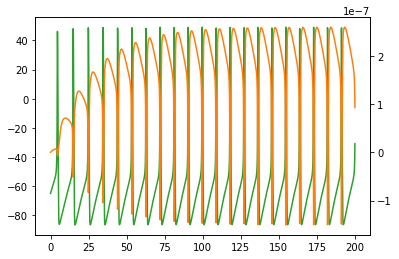

In [554]:
fig, ax1 = plt.subplots()
ax1.plot(t_state/ms,v_state/ms,'C2')

ax2 = ax1.twinx()
ax2.plot(t_state/ms,ih_state/ms,'C1')

t_isi = get_mean_period(spike_train)
print(t_isi)

In [555]:
n_simulations = 40
pulse_strength = -20 * mV

delay_list = np.linspace(0.1 * ms,t_isi - 0.1*ms,n_simulations)
spike_trains_dict = {}

for delay in delay_list:
    run_sim(delay, pulse_strength, record_states=False, duration=100 * ms)
    spike_train = spike_recorder.spike_trains()[0]
#     print(spike_train)
    spike_trains_dict[delay / ms] = spike_train #Careful, delay is not a Quantity anymore because in must be hashable

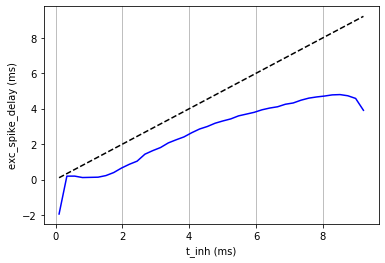

In [556]:
mean_response_dict = get_mean_response(spike_trains_dict, t_isi)
plot_mean_response(mean_response_dict)

In [557]:
# plot_phase_response_curve(mean_response_dict, t_isi)

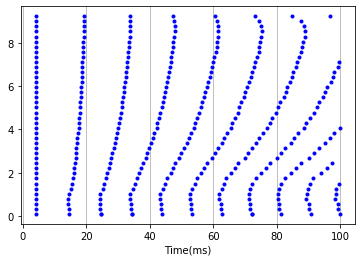

In [558]:
plot_spiking(spike_trains_dict)